## Importing libraries

In [1862]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [1863]:
id_num = ['85065', '85012', '85064', '85030',
      '85054', '95040']
id_n = '85065'

In [1864]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=" + id_n;
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [1865]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

Value       Date
0  276.488 2006-01-01
1  276.482 2006-01-02
2  276.494 2006-01-03
3  276.500 2006-01-04
4  276.500 2006-01-05

<IPython.core.display.Javascript object>


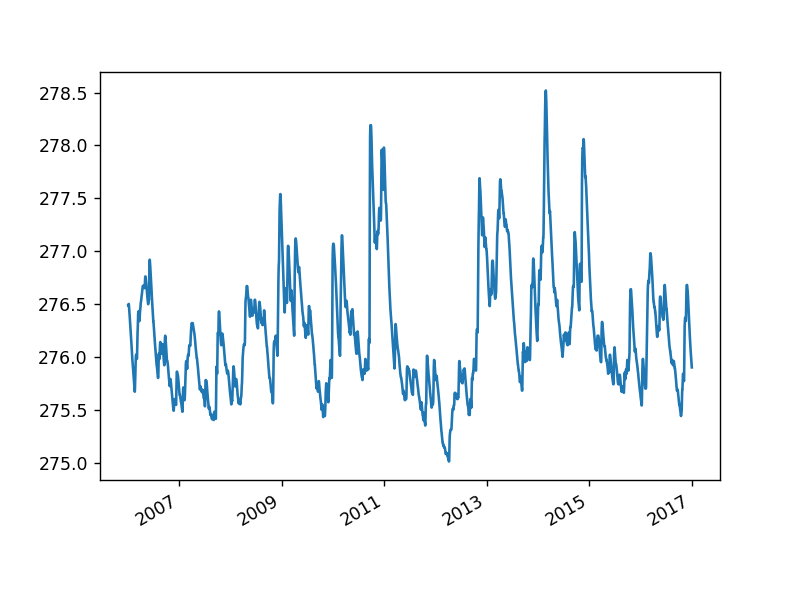

In [1866]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [1867]:
pd.set_option('display.max_rows', 5000)
df['Date']

0      2006-01-01
1      2006-01-02
2      2006-01-03
3      2006-01-04
4      2006-01-05
5      2006-01-06
6      2006-01-07
7      2006-01-08
8      2006-01-09
9      2006-01-10
10     2006-01-11
11     2006-01-12
12     2006-01-13
13     2006-01-14
14     2006-01-15
15     2006-01-16
16     2006-01-17
17     2006-01-18
18     2006-01-19
19     2006-01-20
20     2006-01-21
21     2006-01-22
22     2006-01-23
23     2006-01-24
24     2006-01-25
25     2006-01-26
26     2006-01-27
27     2006-01-28
28     2006-01-29
29     2006-01-30
30     2006-01-31
31     2006-02-01
32     2006-02-02
33     2006-02-03
34     2006-02-04
35     2006-02-05
36     2006-02-06
37     2006-02-07
38     2006-02-08
39     2006-02-09
40     2006-02-10
41     2006-02-11
42     2006-02-12
43     2006-02-13
44     2006-02-14
45     2006-02-15
46     2006-02-16
47     2006-02-17
48     2006-02-18
49     2006-02-19
50     2006-02-20
51     2006-02-21
52     2006-02-22
53     2006-02-23
54     2006-02-24
55     200

In [1868]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2009&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [1869]:
dw[0:5]

CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                    
2010-01-01          97                 0           13.8             0   
2010-01-02         100                 0            4.6             0   
2010-01-03           7                 0            7.9             0   
2010-01-04          77                 0            0.0             0   
2010-01-05         100                10            5.8            10   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2010-01-01           0.0             6.9             7.7             5.5  
2010-01-02           0.0             2.5             6.7             0.7  
2010-01-03           8.0            -0.5             3.4            -2.6  
2010-01-04           0.8            -3.3            -1.6            -6.4  
2010-01-05           0.0            -1.5            -0.5            -2.3

## Data Fusion

In [1870]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [1871]:
df[0:5]

Value
Date               
2006-01-01  276.488
2006-01-02  276.482
2006-01-03  276.494
2006-01-04  276.500
2006-01-05  276.500

In [1872]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [1873]:
ds = ds.loc['2010-01-01':'2015-01-01']

In [1874]:
# let's check it
ds[0:10]

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2010-01-01  277.07        97.0               0.0           13.8           0.0   
2010-01-02  277.07       100.0               0.0            4.6           0.0   
2010-01-03  277.07         7.0               0.0            7.9           0.0   
2010-01-04  277.07        77.0               0.0            0.0           0.0   
2010-01-05  277.06       100.0              10.0            5.8          10.0   
2010-01-06  277.05       100.0               9.0           10.4          18.0   
2010-01-07  277.02       100.0               6.0            4.4          20.0   
2010-01-08  277.00       100.0               1.0            1.7          16.0   
2010-01-09  276.98       100.0              28.0           38.6          44.0   
2010-01-10  276.96       100.0               2.0            7.8          36.0   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2010-01-01           0.0             6.9             7.7             5.5  
2010-01-02           0.0             2.5             6.7             0.7  
2010-01-03           8.0            -0.5             3.4            -2.6  
2010-01-04           0.8            -3.3            -1.6            -6.4  
2010-01-05           0.0            -1.5            -0.5            -2.3  
2010-01-06           0.0            -0.7             0.5            -2.0  
2010-01-07           0.0             0.6             1.2            -0.6  
2010-01-08           0.0            -0.2             0.7            -0.5  
2010-01-09           0.0             0.7             1.5            -0.5  
2010-01-10           0.0             0.8             2.4             0.4

# .........

In [1875]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [1876]:
#dnew = ds
#for i in range(26):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)
#for i in range(50,101,10):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)

In [1877]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [1878]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [1879]:
dnew

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2010-01-01  277.07        97.0               0.0           13.8           0.0   
2010-01-02  277.07       100.0               0.0            4.6           0.0   
2010-01-03  277.07         7.0               0.0            7.9           0.0   
2010-01-04  277.07        77.0               0.0            0.0           0.0   
2010-01-05  277.06       100.0              10.0            5.8          10.0   
2010-01-06  277.05       100.0               9.0           10.4          18.0   
2010-01-07  277.02       100.0               6.0            4.4          20.0   
2010-01-08  277.00       100.0               1.0            1.7          16.0   
2010-01-09  276.98       100.0              28.0           38.6          44.0   
2010-01-10  276.96       100.0               2.0            7.8          36.0   
2010-01-11  276.94       100.0               0.0            0.0          30.0   
2010-01-12  276.91        97.0               1.0            1.5          26.0   
2010-01-13  276.89       100.0               2.0            1.2          23.0   
2010-01-14  276.87       100.0               0.0            0.0          23.0   
2010-01-15  276.84       100.0               0.0            0.2          23.0   
2010-01-16  276.81        93.0               0.0            0.0          23.0   
2010-01-17  276.79        80.0               0.0            0.0          22.0   
2010-01-18  276.77        77.0               2.0            1.9          24.0   
2010-01-19  276.74       100.0               0.0            0.0          23.0   
2010-01-20  276.72        43.0               0.0            0.0          23.0   
2010-01-21  276.69       100.0               0.0            0.0          21.0   
2010-01-22  276.66       100.0               3.0            1.6          23.0   
2010-01-23  276.63       100.0               0.0            0.0          23.0   
2010-01-24  276.61       100.0               0.0            0.0          23.0   
2010-01-25  276.57       100.0               0.0            0.0          22.0   
2010-01-26  276.54        90.0               0.0            0.2          21.0   
2010-01-27  276.50        43.0               1.0            0.6          21.0   
2010-01-28  276.47        67.0               0.0            0.0          20.0   
2010-01-29  276.44        73.0               0.0            0.0          20.0   
2010-01-30  276.41       100.0               9.0            7.4          28.0   
2010-01-31  276.37        83.0              21.0           15.0          48.0   
2010-02-01  276.34        37.0               0.0            0.1          43.0   
2010-02-02  276.31        70.0               0.0            0.0          42.0   
2010-02-03  276.28        70.0               0.0            0.0          38.0   
2010-02-04  276.24        97.0               0.0            0.0          32.0   
2010-02-05  276.22       100.0               0.0            0.1          25.0   
2010-02-06  276.20       100.0               0.0           13.1          22.0   
2010-02-07  276.19       100.0               0.0            0.5          20.0   
2010-02-08  276.19       100.0               0.0            0.0          19.0   
2010-02-09  276.17       100.0               0.0            0.0          18.0   
2010-02-10  276.16       100.0               3.0            1.8          21.0   
2010-02-11  276.14       100.0              21.0           18.3          41.0   
2010-02-12  276.12       100.0               3.0            3.2          43.0   
2010-02-13  276.10        37.0               0.0            0.1          41.0   
2010-02-14  276.08       100.0               0.0            0.0          36.0   
2010-02-15  276.06        97.0               0.0            0.2          33.0   
2010-02-16  276.04        70.0               0.0            0.0          32.0   
2010-02-17  276.03        87.0              

In [1880]:
dnew.corr()

Value  CloudCover  New_snow_blanket  \
Value                        1.000000    0.274829          0.094755   
CloudCover                   0.274829    1.000000          0.142080   
New_snow_blanket             0.094755    0.142080          1.000000   
Percipitation                0.038737    0.240523          0.162416   
Snow_blanket                 0.122265    0.204792          0.552036   
Sun_duration                -0.330819   -0.879486         -0.143944   
TemperatureAvg              -0.352788   -0.420237         -0.213110   
TemperatureMax              -0.377243   -0.529976         -0.221492   
TemperatureMin              -0.299330   -0.205513         -0.189670   
DValue                       0.027445    0.118811         -0.044847   
CloudCover_shift_0d          0.274829    1.000000          0.142080   
CloudCover_shift_1d          0.286642    0.603422          0.154454   
CloudCover_shift_2d          0.300712    0.428934          0.095426   
CloudCover_shift_3d          0.313582    0.324331          0.093803   
CloudCover_shift_4d          0.322642    0.273099          0.072797   
CloudCover_shift_5d          0.328402    0.238201          0.078568   
CloudCover_shift_6d          0.332718    0.222282          0.073142   
CloudCover_shift_7d          0.335525    0.190783          0.071257   
CloudCover_shift_8d          0.336646    0.190404          0.064360   
CloudCover_shift_9d          0.338187    0.192444          0.061799   
CloudCover_shift_10d         0.339941    0.201115          0.076260   
CloudCover_shift_11d         0.341719    0.207258          0.083161   
CloudCover_shift_12d         0.344074    0.208523          0.094045   
CloudCover_shift_13d         0.345994    0.232605          0.066182   
CloudCover_shift_14d         0.348034    0.215728          0.083967   
CloudCover_shift_15d         0.349275    0.223923          0.092008   
CloudCover_shift_16d         0.350581    0.210314          0.080837   
CloudCover_shift_17d         0.351174    0.228911          0.080798   
CloudCover_shift_18d         0.351775    0.213634          0.082693   
CloudCover_shift_19d         0.352479    0.218929          0.079636   
CloudCover_shift_20d         0.353155    0.194212          0.089390   
CloudCover_shift_21d         0.353952    0.169626          0.082404   
CloudCover_shift_22d         0.355276    0.134346          0.070792   
CloudCover_shift_23d         0.356549    0.110251          0.071827   
CloudCover_shift_24d         0.356736    0.104508          0.056075   
CloudCover_shift_25d         0.355178    0.085774          0.092527   
CloudCover_shift_30d         0.330933    0.144308          0.103137   
CloudCover_shift_40d         0.304252    0.171291          0.096712   
CloudCover_shift_50d         0.295426    0.091285          0.007464   
CloudCover_shift_60d         0.279516    0.089167          0.079450   
CloudCover_shift_70d         0.230941    0.033981          0.061002   
CloudCover_shift_80d         0.160801    0.006775          0.074303   
CloudCover_shift_90d         0.137450   -0.023770          0.022231   
CloudCover_shift_100d        0.116859    0.002123          0.037131   
New_snow_blanket_shift_0d    0.094755    0.142080          1.000000   
New_snow_blanket_shift_1d    0.091680    0.095742          0.265859   
New_snow_blanket_shift_2d    0.088788    0.089664          0.193563   
New_snow_blanket_shift_3d    0.085772    0.100937          0.149120   
New_snow_blanket_shift_4d    0.083341    0.123121          0.113164   
New_snow_blanket_shift_5d    0.082290    0.116768          0.053588   
New_snow_blanket_shift_6d    0.083501    0.100336          0.020072   
New_snow_blanket_shift_7d    0.086354    0.079542          0.015413   
New_snow_blanket_shift_8d    0.090401    0.057689          0.006573   
New_snow_blanket_shift_9d    0.094581    0.052181          0.037560   
New_snow_blanket_shift_10d   0.099257    0.088985          0.045380   
New_snow_blanket_shift_11d   0.103426    0.075357       

In [1881]:
#correlation for shifts
#plt.matshow(dnew.corr())

In [1882]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [1883]:
#for i in range(26):
#    dnew['Sun_duration' + '_sum_' + str(i)+'d'] = ds['Sun_duration'].rolling(i).sum()

In [1884]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [1885]:
#dnew2.corr()

<IPython.core.display.Javascript object>


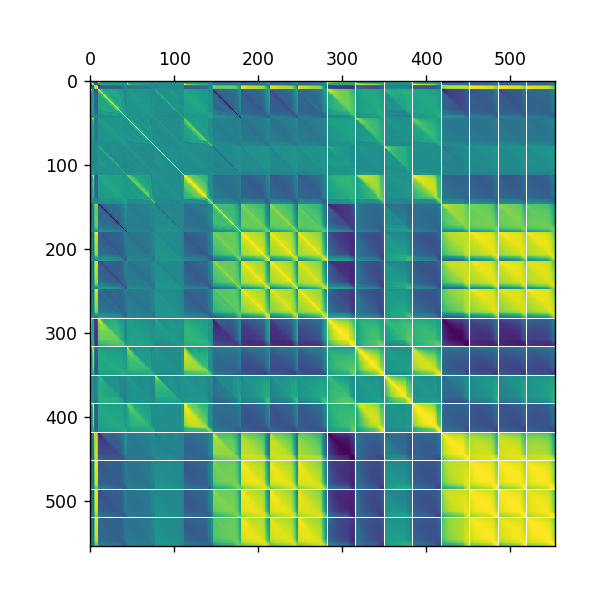

In [1886]:
# correlation for shifts and average
plt.matshow(dnew.corr())

In [1887]:
dnew.corr()['DValue']

Value                            0.027445
CloudCover                       0.118811
New_snow_blanket                -0.044847
Percipitation                    0.457381
Snow_blanket                    -0.076783
Sun_duration                    -0.113747
TemperatureAvg                  -0.017859
TemperatureMax                  -0.031584
TemperatureMin                   0.029301
DValue                           1.000000
CloudCover_shift_0d              0.118811
CloudCover_shift_1d              0.199770
CloudCover_shift_2d              0.235393
CloudCover_shift_3d              0.206290
CloudCover_shift_4d              0.143834
CloudCover_shift_5d              0.100566
CloudCover_shift_6d              0.073929
CloudCover_shift_7d              0.037295
CloudCover_shift_8d              0.019087
CloudCover_shift_9d              0.028871
CloudCover_shift_10d             0.031756
CloudCover_shift_11d             0.030350
CloudCover_shift_12d             0.024096
CloudCover_shift_13d             0

In [1888]:
# sort for corelation with 'DValue' from max to min
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

In [1889]:
pd.set_option('display.max_rows', 1000)
dsort['DValue']

DValue                           1.000000
Percipitation_average_3d         0.780814
Percipitation_average_4d         0.780157
Percipitation_average_5d         0.748609
Percipitation_average_6d         0.709014
Percipitation_average_2d         0.687585
Percipitation_average_7d         0.669847
Percipitation_average_8d         0.637528
Percipitation_shift_1d           0.629819
Percipitation_average_9d         0.610103
Percipitation_average_10d        0.590176
Percipitation_average_11d        0.575449
Percipitation_average_12d        0.559235
Percipitation_average_13d        0.541071
Percipitation_average_14d        0.524484
Percipitation_average_15d        0.505901
Percipitation_average_16d        0.485387
Percipitation_shift_2d           0.480551
Percipitation_average_17d        0.468426
Percipitation_average_18d        0.461497
Percipitation_average_1d         0.457381
Percipitation                    0.457381
Percipitation_shift_0d           0.457381
Percipitation_average_19d        0

<IPython.core.display.Javascript object>


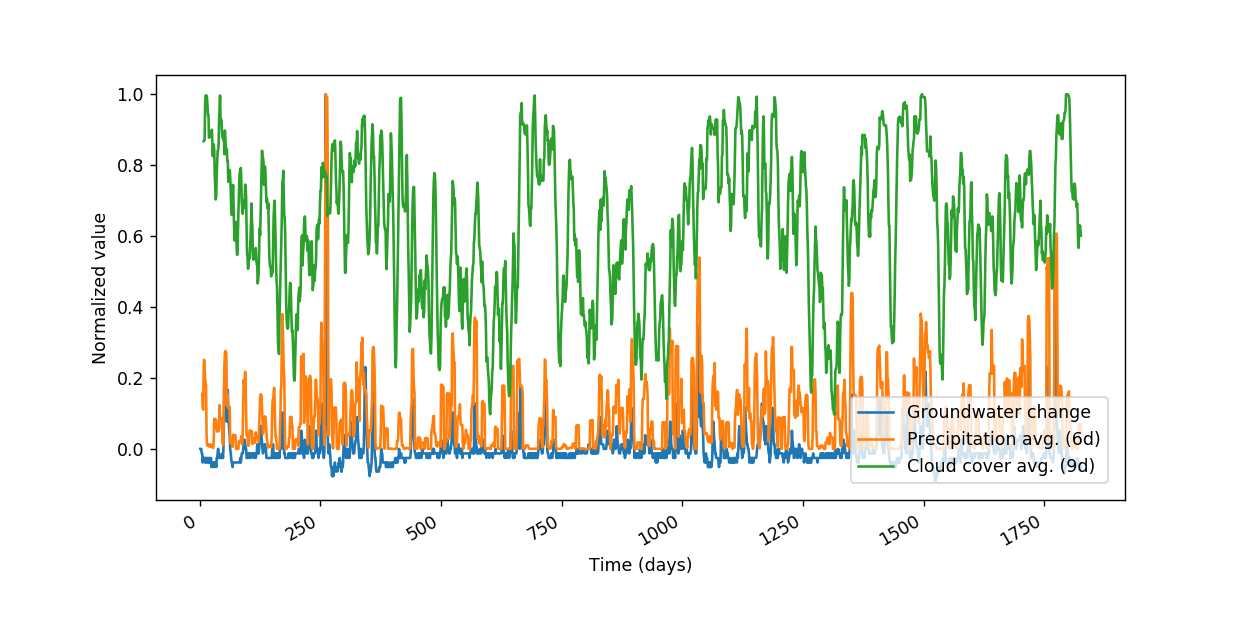

In [1890]:
# ploted corelated quantities
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(dnew['DValue'])), dnew['DValue'] / np.max(np.abs(dnew['DValue']),axis=0), label="Groundwater change");
ax.plot(range(len(dnew['DValue'])), dnew['Percipitation_average_6d'] / np.max(np.abs(dnew['Percipitation_average_6d']),axis=0), label="Precipitation avg. (6d)");
ax.plot(range(len(dnew['DValue'])), dnew['CloudCover_average_9d'] / np.max(np.abs(dnew['CloudCover_average_9d']),axis=0), label="Cloud cover avg. (9d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
plt.show();

In [1891]:
fig.savefig('correlations.png', dpi=300)

In [1892]:
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

Percipitation = dsort['DValue'].index[1]
Sun = dsort['DValue'].index[-1]
for i in dsort['DValue'].index:
    if 'CloudCover' in i:
        Cloud = i
        break

In [1893]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()

corelated = [Percipitation,
             Cloud,
             Sun,
             #'Percipitation_average_6d',
             #'Percipitation_average_10d',
             #'Percipitation_average_25d',
             #'CloudCover_average_9d',
             #'Sun_duration_average_9d'
            ]

corelated = [Percipitation,
             Cloud,
             Sun,
            'Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_18d',             
             'CloudCover_average_9d',
             'Snow_blanket_shift_50d',
             'Snow_blanket_shift_30d',
             'New_snow_blanket_average_60d',
             'Sun_duration_average_10d',
             'Sun_duration_average_3d',
             'TemperatureAvg_average_3d',
             
            ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [1894]:
data_corelated

DValue  Percipitation_average_3d  CloudCover_average_4d  \
Date                                                                  
2010-01-01     NaN                       NaN                    NaN   
2010-01-02    0.00                       NaN                    NaN   
2010-01-03    0.00              8.766667e+00                    NaN   
2010-01-04    0.00              4.166667e+00                  70.25   
2010-01-05   -0.01              4.566667e+00                  71.00   
2010-01-06   -0.01              5.400000e+00                  71.00   
2010-01-07   -0.03              6.866667e+00                  94.25   
2010-01-08   -0.02              5.500000e+00                 100.00   
2010-01-09   -0.02              1.490000e+01                 100.00   
2010-01-10   -0.02              1.603333e+01                 100.00   
2010-01-11   -0.02              1.546667e+01                 100.00   
2010-01-12   -0.03              3.100000e+00                  99.25   
2010-01-13   -0.02              9.000000e-01                  99.25   
2010-01-14   -0.02              9.000000e-01                  99.25   
2010-01-15   -0.03              4.666667e-01                  99.25   
2010-01-16   -0.03              6.666667e-02                  98.25   
2010-01-17   -0.02              6.666667e-02                  93.25   
2010-01-18   -0.02              6.333333e-01                  87.50   
2010-01-19   -0.03              6.333333e-01                  87.50   
2010-01-20   -0.02              6.333333e-01                  75.00   
2010-01-21   -0.03             -3.330669e-15                  80.00   
2010-01-22   -0.03              5.333333e-01                  85.75   
2010-01-23   -0.03              5.333333e-01                  85.75   
2010-01-24   -0.02              5.333333e-01                 100.00   
2010-01-25   -0.04             -3.330669e-15                 100.00   
2010-01-26   -0.03              6.666667e-02                  97.50   
2010-01-27   -0.04              2.666667e-01                  83.25   
2010-01-28   -0.03              2.666667e-01                  75.00   
2010-01-29   -0.03              2.000000e-01                  68.25   
2010-01-30   -0.03              2.466667e+00                  70.75   
2010-01-31   -0.04              7.466667e+00                  80.75   
2010-02-01   -0.03              7.500000e+00                  73.25   
2010-02-02   -0.03              5.033333e+00                  72.50   
2010-02-03   -0.03              3.333333e-02                  65.00   
2010-02-04   -0.04             -2.488750e-15                  68.50   
2010-02-05   -0.02              3.333333e-02                  84.25   
2010-02-06   -0.02              4.400000e+00                  91.75   
2010-02-07   -0.01              4.566667e+00                  99.25   
2010-02-08    0.00              4.533333e+00                 100.00   
2010-02-09   -0.02              1.666667e-01                 100.00   
2010-02-10   -0.01              6.000000e-01                 100.00   
2010-02-11   -0.02              6.700000e+00                 100.00   
2010-02-12   -0.02              7.766667e+00                 100.00   
2010-02-13   -0.02              7.200000e+00                  84.25   
2010-02-14   -0.02              1.100000e+00                  84.25   
2010-02-15   -0.02              1.000000e-01                  83.50   
2010-02-16   -0.02              6.666667e-02                  76.00   
2010-02-17   -0.01              4.000000e-01                  88.50   
2010-02-18   -0.02              9.000000e-01                  87.75   
2010-02-19    0.00              1.100000e+00                  87.75   
2010-02-20    0.07              1.456667e+01                  95.25   
2010-02-21    0.16              2.063333e+01                  89.25   
2010-02-22    0.14              2.363333e+01                  89.25   
2010-02-23    0.11              1.060000e+01                  84.25   
2010-02-24    0.07              4.06

# Learn

In [1895]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [1896]:
n=data_corelated['DValue'].isnull().sum()
data_corelated = data_corelated.fillna(0); #missing data replace vith 0
n

1

In [1897]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[100:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[100:]

In [1898]:
(y.shape,X.shape)

((1727,), (1727, 14))

In [1899]:
(np.isnan(y).any(),np.isnan(X).any())

(False, False)

In [1900]:
#choose regressor

regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = RandomForestRegressor();
#regressor = SVR();
#regressor = GradientBoostingRegressor();

In [1901]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


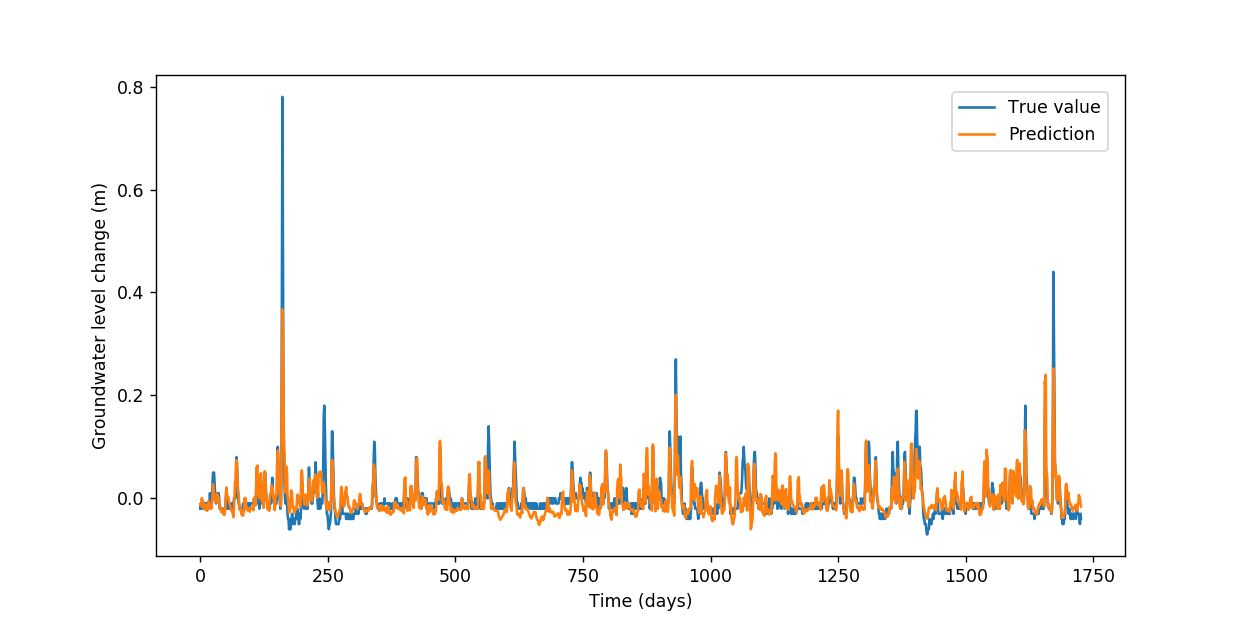

In [1902]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(y)), y, label="True value")
ax.plot(range(len(y)), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [1903]:
#fig.savefig('./graphs/prediction_'+'id='+ id_n +'.png', dpi=300)

In [1904]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.0006998877082529172, 0.6297895783670469)

In [1905]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            GradientBoostingRegressor(),
            SVR(),
            MLPRegressor()
            )

for regressor in regressor_list:
    predicted2 = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted2)
    r2 = r2_score(y, predicted2);
    print(mse, r2)

0.0006998877082529172 0.6297895783670469
0.0011687898089171472 0.3817605840805074
0.0006789797336421262 0.6408489954776484
0.0006502596377126594 0.656040687942041
0.00710824352063723 -2.759954346696225
0.060620621266444887 -31.065694959443633


In [1906]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[100:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


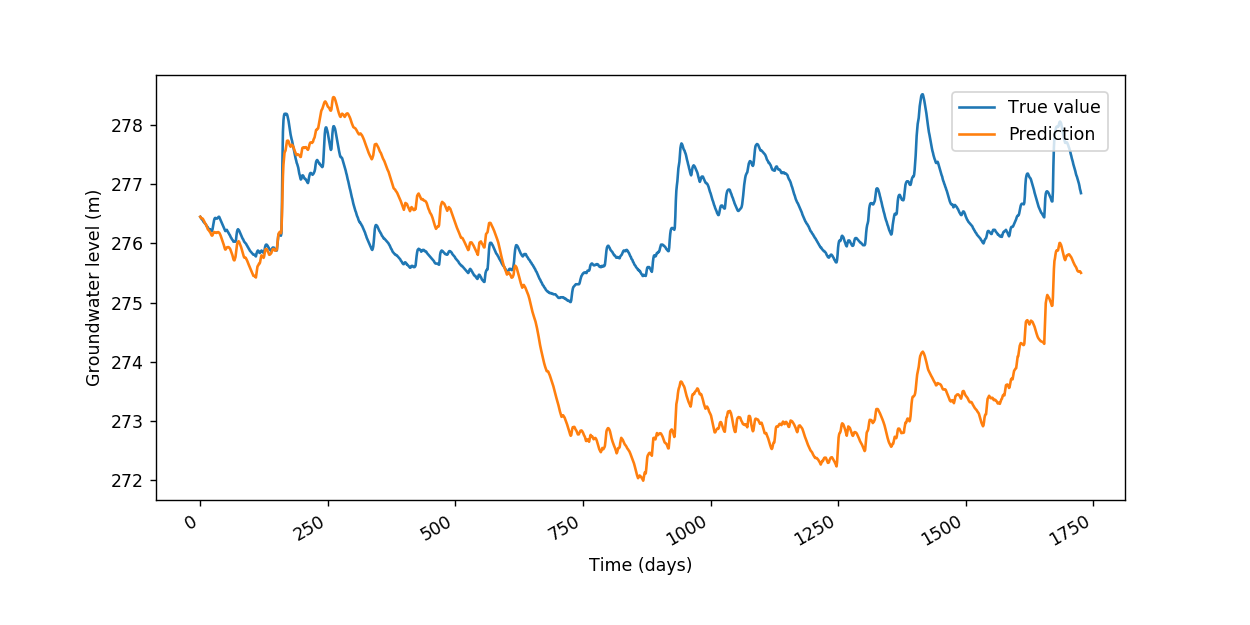

In [1907]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(len(value)), value, label="True value");
ax.plot(range(len(value)), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [1908]:
#fig.savefig('./graphs/prediction_cum_'+'id='+ id_n +'.png', dpi=300)